## 2023 La Nina Cruise ADCP transect plts and cleanup<br>
This notebook shows zonal and meridional velocity component graphs for the 2023 La Nina Cruise. The goal is to take a look at the data and get it ready for calculating mixing metrics<br>
Note that this notebook utilizes code from Susan Hautala and code inspired by ChatGPT

In [59]:
# Dependencies
import matplotlib.pyplot as plt
import matplotlib as mpl


import numpy as np
import pandas as pd
import xarray as xr
import math
import gsw

import mixsea as mx

In [60]:
mpl.rcParams.update({
    'font.size': 14,           # Default font size
    'axes.labelsize': 14,      # Font size for axis labels
    'axes.titlesize': 16,      # Font size for titles
    'xtick.labelsize': 12,     # Font size for x-axis ticks
    'ytick.labelsize': 12,     # Font size for y-axis ticks
    'legend.fontsize': 12,     # Font size for legend
    'figure.titlesize': 18     # Font size for figure titles
})

In [268]:
# Load ADCP Data
datadir = 'data/2023/adcp' 
filepathadcp = datadir+'/os75nb.nc' # filepath
ADCP = xr.open_dataset(filepathadcp, decode_times=False) # open dataset

Let's extract our data from the dataset and remove large NaN gaps that came from masking stationary ADCP data due to CTD casts

In [269]:
ADCPx = ADCP_all.sel(time=slice(62.08, 65.65))
vx = np.array(ADCPx['v'].where(ADCP1['pflag'] == 0))
ux = np.array(ADCPx['u'].where(ADCP1['pflag'] == 0))
zx = np.array(ADCPx['depth'].values)
lonx = np.array(ADCPx['lon'].values)
latx = np.array(ADCPx['lat'].values)

In [346]:
ADCP1 = ADCP_all.sel(time=slice(62.08, 62.33))
v1 = np.array(ADCP1['v'].where(ADCP1['pflag'] == 0))
u1 = np.array(ADCP1['u'].where(ADCP1['pflag'] == 0))
z1 = np.array(ADCP1['depth'].values)
lon1 = np.array(ADCP1['lon'].values)
lat1 = np.array(ADCP1['lat'].values)

ADCP2 = ADCP_all.sel(time=slice(62.41, 62.62))
v2 = np.array(ADCP2['v'].where(ADCP2['pflag'] == 0))
u2 = np.array(ADCP2['u'].where(ADCP2['pflag'] == 0))
z2 = np.array(ADCP2['depth'].values)
lon2 = np.array(ADCP2['lon'].values)
lat2 = np.array(ADCP2['lat'].values)

ADCP3 = ADCP_all.sel(time=slice(62.75, 62.95))
v3 = np.array(ADCP3['v'].where(ADCP3['pflag'] == 0))
u3 = np.array(ADCP3['u'].where(ADCP3['pflag'] == 0))
z3 = np.array(ADCP3['depth'].values)
lon3 = np.array(ADCP3['lon'].values)
lat3 = np.array(ADCP3['lat'].values)

ADCP4 = ADCP_all.sel(time=slice(63.06, 63.18))
v4 = np.array(ADCP4['v'].where(ADCP4['pflag'] == 0))
u4 = np.array(ADCP4['u'].where(ADCP4['pflag'] == 0))
z4 = np.array(ADCP4['depth'].values)
lon4 = np.array(ADCP4['lon'].values)
lat4 = np.array(ADCP4['lat'].values)

ADCP5 = ADCP_all.sel(time=slice(63.25, 63.35))
v5 = np.array(ADCP5['v'].where(ADCP5['pflag'] == 0))
u5 = np.array(ADCP5['u'].where(ADCP5['pflag'] == 0))
z5 = np.array(ADCP5['depth'].values)
lon5 = np.array(ADCP5['lon'].values)
lat5 = np.array(ADCP5['lat'].values)

ADCP6 = ADCP_all.sel(time=slice(63.45, 63.55))
v6 = np.array(ADCP6['v'].where(ADCP6['pflag'] == 0))
u6 = np.array(ADCP6['u'].where(ADCP6['pflag'] == 0))
z6 = np.array(ADCP6['depth'].values)
lon6 = np.array(ADCP6['lon'].values)
lat6 = np.array(ADCP6['lat'].values)

ADCP7 = ADCP_all.sel(time=slice(63.62, 63.74))
v7 = np.array(ADCP7['v'].where(ADCP7['pflag'] == 0))
u7 = np.array(ADCP7['u'].where(ADCP7['pflag'] == 0))
z7 = np.array(ADCP7['depth'].values)
lon7 = np.array(ADCP7['lon'].values)
lat7 = np.array(ADCP7['lat'].values)

ADCP8 = ADCP_all.sel(time=slice(64, 64.13))
v8 = np.array(ADCP8['v'].where(ADCP8['pflag'] == 0))
u8 = np.array(ADCP8['u'].where(ADCP8['pflag'] == 0))
z8 = np.array(ADCP8['depth'].values)
lon8 = np.array(ADCP8['lon'].values)
lat8 = np.array(ADCP8['lat'].values)

ADCP9 = ADCP_all.sel(time=slice(64.22, 64.32))
v9 = np.array(ADCP9['v'].where(ADCP9['pflag'] == 0))
u9 = np.array(ADCP9['u'].where(ADCP9['pflag'] == 0))
z9 = np.array(ADCP9['depth'].values)
lon9 = np.array(ADCP9['lon'].values)
lat9 = np.array(ADCP9['lat'].values)

ADCP10 = ADCP_all.sel(time=slice(64.41, 64.50))
v10 = np.array(ADCP10['v'].where(ADCP10['pflag'] == 0))
u10 = np.array(ADCP10['u'].where(ADCP10['pflag'] == 0))
z10 = np.array(ADCP10['depth'].values)
lon10 = np.array(ADCP10['lon'].values)
lat10 = np.array(ADCP10['lat'].values)

ADCP11 = ADCP_all.sel(time=slice(64.61, 65.73))
v11 = np.array(ADCP11['v'].where(ADCP11['pflag'] == 0))
u11 = np.array(ADCP11['u'].where(ADCP11['pflag'] == 0))
z11 = np.array(ADCP11['depth'].values)
lon11 = np.array(ADCP11['lon'].values)
lat11 = np.array(ADCP11['lat'].values)

ADCP12 = ADCP_all.sel(time=slice(64.82, 65.04))
v12 = np.array(ADCP12['v'].where(ADCP12['pflag'] == 0))
u12 = np.array(ADCP12['u'].where(ADCP12['pflag'] == 0))
z12 = np.array(ADCP12['depth'].values)
lon12 = np.array(ADCP12['lon'].values)
lat12 = np.array(ADCP12['lat'].values)

ADCP13 = ADCP_all.sel(time=slice(65.14, 65.34))
v13 = np.array(ADCP13['v'].where(ADCP13['pflag'] == 0))
u13 = np.array(ADCP13['u'].where(ADCP13['pflag'] == 0))
z13 = np.array(ADCP13['depth'].values)
lon13 = np.array(ADCP13['lon'].values)
lat13 = np.array(ADCP13['lat'].values)

ADCP14 = ADCP_all.sel(time=slice(65.43, 65.65))
v14 = np.array(ADCP14['v'].where(ADCP14['pflag'] == 0))
u14 = np.array(ADCP14['u'].where(ADCP14['pflag'] == 0))
z14 = np.array(ADCP14['depth'].values)
lon14 = np.array(ADCP14['lon'].values)
lat14 = np.array(ADCP14['lat'].values)

v = np.concatenate((v1, v2, v3, v4, v5, v6, v7, v8, v9, v10, v11, v12, v13, v14))
u = np.concatenate((u1, u2, u3, u4, u5, u6, u7, u8, u9, u10, u11, u12, u13, u14))
lat = np.concatenate((lat1, lat2, lat3, lat4, lat5, lat6, lat7, lat8, lat9, lat10, lat11, lat12, lat13, lat14))
z = np.concatenate((z1, z2, z3, z4, z5, z6, z7, z8, z9, z10, z11, z12, z13, z14))

In [342]:
ADCP6 = ADCP_all.sel(time=slice(63.45, 63.55))
v6 = np.array(ADCP6['v'].where(ADCP6['pflag'] == 0))
u6 = np.array(ADCP6['u'].where(ADCP6['pflag'] == 0))
z6 = np.array(ADCP6['depth'].values)
lon6 = np.array(ADCP6['lon'].values)
lat6 = np.array(ADCP6['lat'].values)

ADCP9 = ADCP_all.sel(time=slice(64.22, 64.32))
v9 = np.array(ADCP9['v'].where(ADCP9['pflag'] == 0))
u9 = np.array(ADCP9['u'].where(ADCP9['pflag'] == 0))
z9 = np.array(ADCP9['depth'].values)
lon9 = np.array(ADCP9['lon'].values)
lat9 = np.array(ADCP9['lat'].values)

In [347]:
_shape = np.shape(v)
time = _shape[0]
depth_bins = _shape[1]
depth_mesh, lat_mesh = np.meshgrid(np.arange(depth_bins), lat)

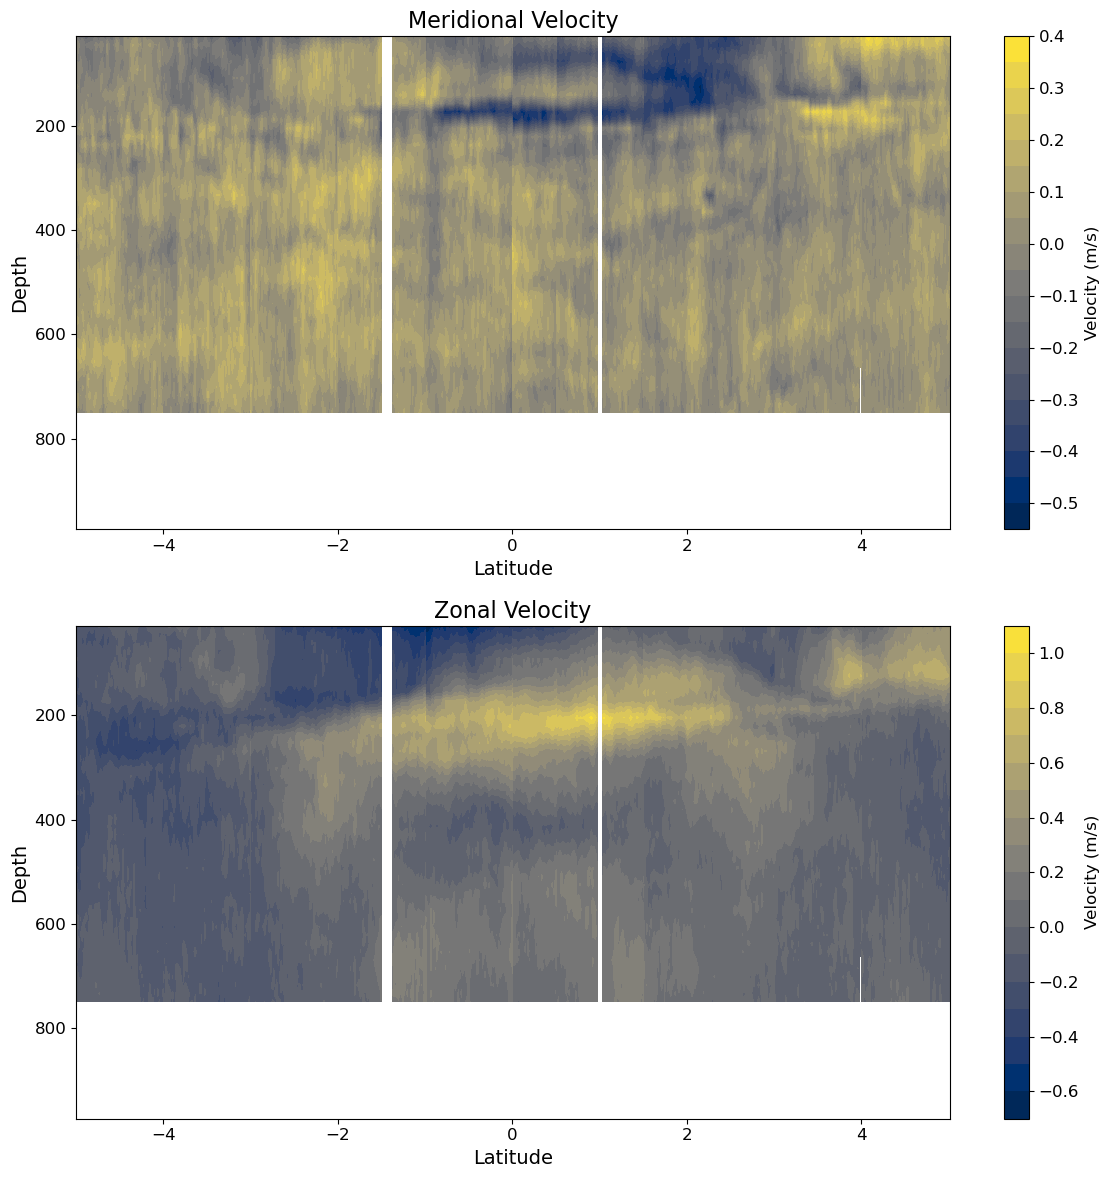

In [348]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# meridional velocity
contour1 = ax1.contourf(lat_mesh, z, v, levels=20, cmap='cividis')
ax1.invert_yaxis()
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Depth')
colorbar1 = plt.colorbar(contour1, ax=ax1)
colorbar1.set_label('Velocity (m/s)', fontsize=12)
ax1.set_title('Meridional Velocity')

# zonal
contour2 = ax2.contourf(lat_mesh, z, u, levels=20, cmap='cividis')
ax2.invert_yaxis()
ax2.set_xlabel('Latitude')
ax2.set_ylabel('Depth')
colorbar2 = plt.colorbar(contour2, ax=ax2)
colorbar2.set_label('Velocity (m/s)', fontsize=12)
ax2.set_title('Zonal Velocity')

plt.tight_layout()

Let's save the ADCP data for use in 